In [63]:
import warnings
warnings.filterwarnings("ignore")

import re
import json
import csv
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch
from cycler import cycler

In [64]:
#rcParams default settings
"https://matplotlib.org/stable/tutorials/introductory/customizing.html"

#rcParams settings
plt.style.use('ggplot')

rcParams['font.family'] = 'sans-serif'
rcParams['font.style'] = 'normal'

rcParams['figure.facecolor'] = 'white'

rcParams['savefig.bbox'] = 'tight'
rcParams['savefig.dpi'] = 300
rcParams['savefig.transparent'] = True

rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['axes.labelsize'] = 20
rcParams['axes.labelcolor'] = 'black'
rcParams['axes.edgecolor'] = 'grey'
rcParams['axes.linewidth'] = 3
rcParams['axes.facecolor'] = 'white'
rcParams['axes.titlepad'] = 4
rcParams['axes.titlesize'] = 20

rcParams['xtick.color'] = 'grey'
rcParams['ytick.color'] = 'grey'
rcParams['xtick.labelsize'] = 15
rcParams['ytick.labelsize'] = 15
rcParams['xtick.major.width'] = 2
rcParams['ytick.major.width'] = 0
rcParams['xtick.major.size'] = 5
rcParams['ytick.major.size'] = 0

rcParams['lines.linewidth'] = 3
rcParams['lines.markersize'] = 10

rcParams['legend.title_fontsize'] = 15
rcParams['legend.fontsize'] = 10

rcParams['grid.color'] = 'grey'
rcParams['grid.linewidth'] = 0.1

icefire_palette = sns.color_palette("icefire")
sns.set_palette(icefire_palette)

# Functions

In [65]:
# Function to clean tweets
def preliminary_cleaning(t):              
    # Convert to lowercase
    text = t.lower()
        
    # Remove newlines, tabs, and extra whitespace
    text = text.replace('\n', ' ').replace('\t', ' ').replace('&amp;', '&').replace('&gt;', '')
    text = re.sub(r'\s+', ' ', text).strip()
    
    def remove_urls(text):
        # Define the regex pattern for URLs
        url_pattern = re.compile(r'https?://\S+|www\.\S+')
        # Use the sub method to replace URLs with an empty string
        cleaned_text = re.sub(url_pattern, '', text)
        return cleaned_text

    def remove_usernames(text):
        # Use a regular expression to find all @usernames at the beginning of the text
        cleaned_text = re.sub(r'^(@\w+\s*)+', '', text)
        return cleaned_text
    
    text = remove_urls(text)
    
    text = remove_usernames(text)
    
    return text

# Function to capitalize and replace specific usernames
def format_username(username):
    # Dictionary for specific replacements
    specific_replacements = {
        'lego_group': 'Lego Group',
        'hm': 'H&M',
        'detushepostdhl': 'DHL',
        'iberdrola_en': 'Iberdrola'
    }
    # Apply specific replacements if available
    if username in specific_replacements:
        return specific_replacements[username]
    # General case for handling 'group'
    if 'group' in username.lower():
        parts = username.split('group')
        return ' '.join([part.capitalize() for part in parts if part]) + ' Group'
    # Capitalize other usernames
    return username.capitalize()

# Reading Data

In [122]:
df = pd.read_json("/home/pansanella/mydata/github/almondo-tweets-retrieval/data/out/filtered_tweets_4.json")

In [123]:
df.head()

,attachments,author_id,created_at,edit_history_tweet_ids,entities,id,lang,public_metrics,text,username,geo
0,{'media_keys': ['13_1610292861630840833']},51801586,2023-01-03 15:18:41+00:00,[1610294585242300416],"{'annotations': [{'end': 6, 'normalized_text':...",1610294585242300416,en,"{'bookmark_count': 0, 'impression_count': 3864...",New ABB E-mobility home charging solution help...,abbgroupnews,NaN
1,{'media_keys': ['3_1612750081463095296']},51801586,2023-01-10 09:57:29+00:00,[1612750467859378178],"{'annotations': [{'end': 2, 'normalized_text':...",1612750467859378176,en,"{'bookmark_count': 0, 'impression_count': 4887...",ABB #technology to facilitate #energyefficienc...,abbgroupnews,NaN
2,{'media_keys': ['13_1613112174939103235']},51801586,2023-01-11 10:01:06+00:00,[1613113765595320321],"{'annotations': [{'end': 51, 'normalized_text'...",1613113765595320320,en,"{'bookmark_count': 0, 'impression_count': 2559...",Better decisions for a greener data center! Ho...,abbgroupnews,NaN
3,{'media_keys': ['3_1613462741569736704']},51801586,2023-01-12 09:09:45+00:00,[1613463229665271809],"{'annotations': [{'end': 19, 'normalized_text'...",1613463229665271808,en,"{'bookmark_count': 0, 'impression_count': 2087...",ABB Formula E Season 9 goes green in Mexico!\n...,abbgroupnews,NaN
4,{'media_keys': ['13_1613831618141261825']},51801586,2023-01-13 09:41:43+00:00,[1613833662625353729],"{'annotations': [{'end': 7, 'normalized_text':...",1613833662625353728,en,"{'bookmark_count': 0, 'impression_count': 1975...",The #ABB Decoded #podcast with Frank Muehlon i...,abbgroupnews,NaN


# Cleaning Data

###### Plot Palette Setting

In [124]:
icefire_palette = sns.color_palette("icefire", n_colors=len(df.username.unique()))
tab20_palette = sns.color_palette("tab20", n_colors=20)
tab10_palette = sns.color_palette("tab10", n_colors=10)

# Metrics Analysis

In [125]:
df['public_metrics']# Use pandas.json_normalize to expand the dictionaries into separate columns
public_metrics_expanded = pd.json_normalize(df['public_metrics'])
df = df.join(public_metrics_expanded)

In [126]:
entities_expanded = pd.json_normalize(df['entities'])
df = df.join(entities_expanded)
df.head()

,attachments,author_id,created_at,edit_history_tweet_ids,entities,id,lang,public_metrics,text,username,...,impression_count,like_count,quote_count,reply_count,retweet_count,annotations,hashtags,urls,mentions,cashtags
0,{'media_keys': ['13_1610292861630840833']},51801586,2023-01-03 15:18:41+00:00,[1610294585242300416],"{'annotations': [{'end': 6, 'normalized_text':...",1610294585242300416,en,"{'bookmark_count': 0, 'impression_count': 3864...",New ABB E-mobility home charging solution help...,abbgroupnews,...,3864,19,2,0,7,"[{'end': 6, 'normalized_text': 'ABB', 'probabi...","[{'end': 138, 'start': 134, 'tag': 'ABB'}, {'e...","[{'display_url': 'social.abb/e-mobility-hom…',...",NaN,NaN
1,{'media_keys': ['3_1612750081463095296']},51801586,2023-01-10 09:57:29+00:00,[1612750467859378178],"{'annotations': [{'end': 2, 'normalized_text':...",1612750467859378176,en,"{'bookmark_count': 0, 'impression_count': 4887...",ABB #technology to facilitate #energyefficienc...,abbgroupnews,...,4887,11,2,0,4,"[{'end': 2, 'normalized_text': 'ABB', 'probabi...","[{'end': 15, 'start': 4, 'tag': 'technology'},...","[{'display_url': 'social.abb/technology-ene…',...",NaN,NaN
2,{'media_keys': ['13_1613112174939103235']},51801586,2023-01-11 10:01:06+00:00,[1613113765595320321],"{'annotations': [{'end': 51, 'normalized_text'...",1613113765595320320,en,"{'bookmark_count': 0, 'impression_count': 2559...",Better decisions for a greener data center! Ho...,abbgroupnews,...,2559,17,0,0,5,"[{'end': 51, 'normalized_text': 'ABB', 'probab...","[{'end': 52, 'start': 48, 'tag': 'ABB'}, {'end...","[{'display_url': 'social.abb/ability-kangsh…',...",NaN,NaN
3,{'media_keys': ['3_1613462741569736704']},51801586,2023-01-12 09:09:45+00:00,[1613463229665271809],"{'annotations': [{'end': 19, 'normalized_text'...",1613463229665271808,en,"{'bookmark_count': 0, 'impression_count': 2087...",ABB Formula E Season 9 goes green in Mexico!\n...,abbgroupnews,...,2087,8,0,0,4,"[{'end': 19, 'normalized_text': 'ABB Formula E...","[{'end': 116, 'start': 112, 'tag': 'ABB'}]","[{'display_url': 'social.abb/formula-goes-g…',...",NaN,NaN
4,{'media_keys': ['13_1613831618141261825']},51801586,2023-01-13 09:41:43+00:00,[1613833662625353729],"{'annotations': [{'end': 7, 'normalized_text':...",1613833662625353728,en,"{'bookmark_count': 0, 'impression_count': 1975...",The #ABB Decoded #podcast with Frank Muehlon i...,abbgroupnews,...,1975,7,0,0,1,"[{'end': 7, 'normalized_text': 'ABB', 'probabi...","[{'end': 8, 'start': 4, 'tag': 'ABB'}, {'end':...","[{'display_url': 'social.abb/decoded-podcas…',...",NaN,NaN


In [129]:
# Function to extract tags
def extract_tags(tag_list):
    if type(tag_list) == list:
        return [entry['tag'] for entry in tag_list]
    else:
        return None

# Apply the function to create a new column 'hashtags'
df['hashtags'] = df['hashtags'].apply(extract_tags)

df.head()

,attachments,author_id,created_at,edit_history_tweet_ids,entities,id,lang,public_metrics,text,username,...,impression_count,like_count,quote_count,reply_count,retweet_count,annotations,hashtags,urls,mentions,cashtags
0,{'media_keys': ['13_1610292861630840833']},51801586,2023-01-03 15:18:41+00:00,[1610294585242300416],"{'annotations': [{'end': 6, 'normalized_text':...",1610294585242300416,en,"{'bookmark_count': 0, 'impression_count': 3864...",New ABB E-mobility home charging solution help...,abbgroupnews,...,3864,19,2,0,7,"[{'end': 6, 'normalized_text': 'ABB', 'probabi...","[ABB, electricvehicles, emobility, sustainabil...","[{'display_url': 'social.abb/e-mobility-hom…',...",NaN,NaN
1,{'media_keys': ['3_1612750081463095296']},51801586,2023-01-10 09:57:29+00:00,[1612750467859378178],"{'annotations': [{'end': 2, 'normalized_text':...",1612750467859378176,en,"{'bookmark_count': 0, 'impression_count': 4887...",ABB #technology to facilitate #energyefficienc...,abbgroupnews,...,4887,11,2,0,4,"[{'end': 2, 'normalized_text': 'ABB', 'probabi...","[technology, energyefficiency, software, ABBFo...","[{'display_url': 'social.abb/technology-ene…',...",NaN,NaN
2,{'media_keys': ['13_1613112174939103235']},51801586,2023-01-11 10:01:06+00:00,[1613113765595320321],"{'annotations': [{'end': 51, 'normalized_text'...",1613113765595320320,en,"{'bookmark_count': 0, 'impression_count': 2559...",Better decisions for a greener data center! Ho...,abbgroupnews,...,2559,17,0,0,5,"[{'end': 51, 'normalized_text': 'ABB', 'probab...","[ABB, data, betterdecisions, ABB_Ability, sust...","[{'display_url': 'social.abb/ability-kangsh…',...",NaN,NaN
3,{'media_keys': ['3_1613462741569736704']},51801586,2023-01-12 09:09:45+00:00,[1613463229665271809],"{'annotations': [{'end': 19, 'normalized_text'...",1613463229665271808,en,"{'bookmark_count': 0, 'impression_count': 2087...",ABB Formula E Season 9 goes green in Mexico!\n...,abbgroupnews,...,2087,8,0,0,4,"[{'end': 19, 'normalized_text': 'ABB Formula E...",[ABB],"[{'display_url': 'social.abb/formula-goes-g…',...",NaN,NaN
4,{'media_keys': ['13_1613831618141261825']},51801586,2023-01-13 09:41:43+00:00,[1613833662625353729],"{'annotations': [{'end': 7, 'normalized_text':...",1613833662625353728,en,"{'bookmark_count': 0, 'impression_count': 1975...",The #ABB Decoded #podcast with Frank Muehlon i...,abbgroupnews,...,1975,7,0,0,1,"[{'end': 7, 'normalized_text': 'ABB', 'probabi...","[ABB, podcast, EV, technology, motorsport, ABB...","[{'display_url': 'social.abb/decoded-podcas…',...",NaN,NaN


# Public metrics analysis

#### Metrics distribution

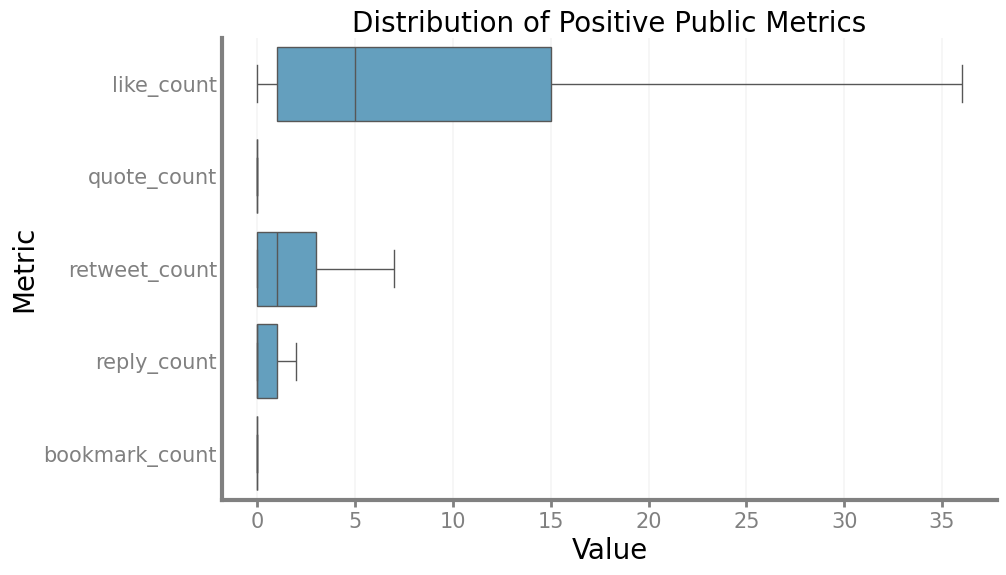

In [82]:
df_plot = df.melt(value_vars=['like_count', 'quote_count', 'retweet_count', 'reply_count', 'bookmark_count'], 
                    var_name='Metric', value_name='Value')

plt.figure(figsize=(10, 6))
sns.boxplot(x='Value', y='Metric', data=df_plot.loc[df_plot.Metric != 'impression_count'], orient='h', showfliers=False)

plt.title('Distribution of Positive Public Metrics')
plt.xlabel('Value')
plt.ylabel('Metric')
plt.show()

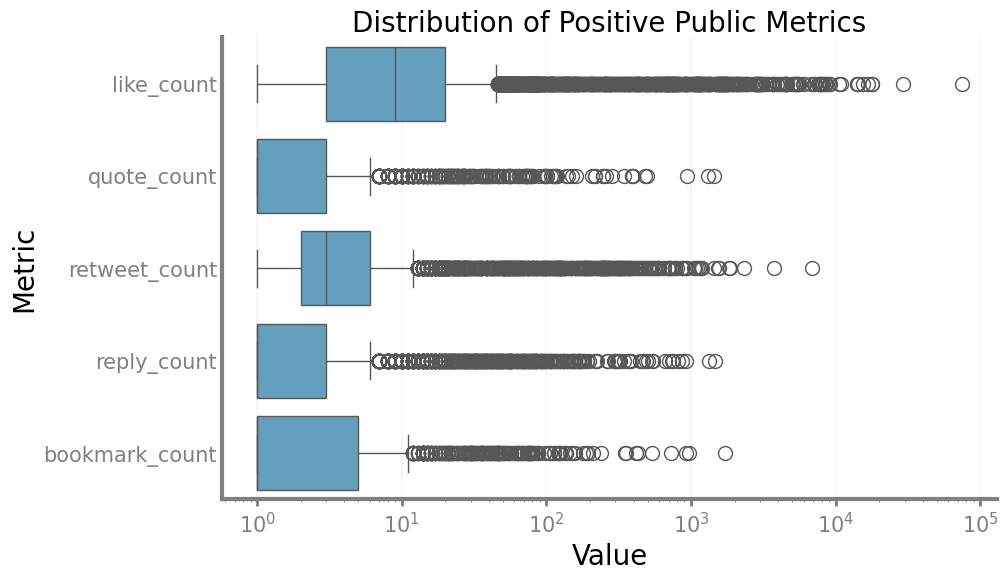

In [84]:
df_melted = df.melt(value_vars=['like_count', 'quote_count', 'retweet_count', 'reply_count', 'bookmark_count', 'impression_count'], 
                    var_name='Metric', value_name='Value')

df_melted_positive = df_melted[df_melted['Value'] > 0]

plt.figure(figsize=(10, 6))
sns.boxplot(x='Value', y='Metric', data=df_melted_positive.loc[df_melted_positive.Metric != 'impression_count'], orient='h')

plt.title('Distribution of Positive Public Metrics')
plt.xlabel('Value')
plt.xscale('log')
plt.ylabel('Metric')
plt.show()

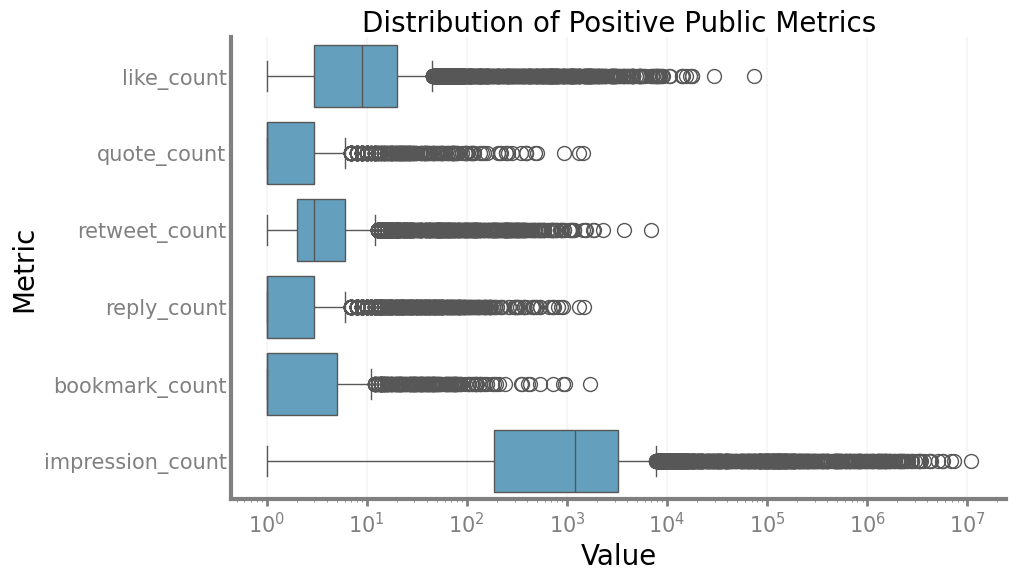

In [71]:
df_melted = df.melt(value_vars=['like_count', 'quote_count', 'retweet_count', 'reply_count', 'bookmark_count', 'impression_count'], 
                    var_name='Metric', value_name='Value')

df_melted_positive = df_melted[df_melted['Value'] > 0]

plt.figure(figsize=(10, 6))
sns.boxplot(x='Value', y='Metric', data=df_melted_positive, orient='h')

plt.title('Distribution of Positive Public Metrics')
plt.xlabel('Value')
plt.xscale('log')
plt.ylabel('Metric')
plt.show()


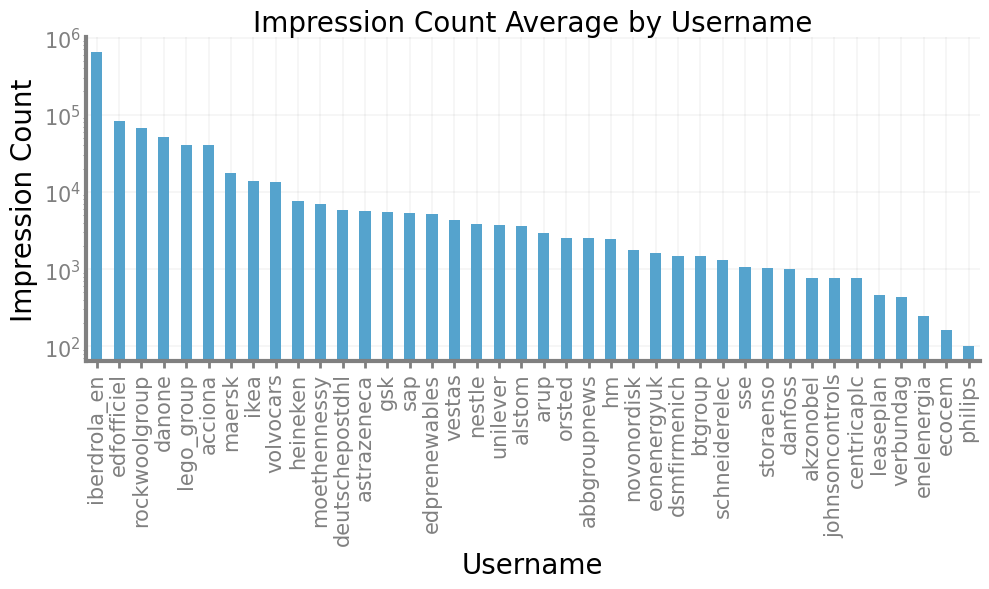

In [114]:
# Group by 'username' and sum the 'impression_count' for each user
grouped = df.groupby('username')['impression_count'].mean()

# Sort the grouped data in descending order of impression counts
grouped = grouped.sort_values(ascending=False)

# Plotting the bar plot
plt.figure(figsize=(10, 6))  # Adjust the figure size if necessary
grouped.plot(kind='bar')
plt.xlabel('Username')
plt.ylabel('Impression Count')
plt.yscale('log')
plt.title('Impression Count Average by Username')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability if needed
plt.tight_layout()

#### actions by user

In [ ]:
actions = ['like', 'quote', 'retweet', 'reply']

In [107]:
df_plot = df.groupby('username')[[f'{action}_count' for action in actions]].sum() 
df_plot['total_count'] = df_plot[['like_count', 'quote_count', 'retweet_count', 'reply_count']].sum(axis=1)

for action in actions:
    df_plot[f'{action}_count_normalized'] = df_plot[f'{action}_count'] / df_plot['total_count']

df_plot = df_plot.sort_values(by='total_count', ascending = False)

df_plot

,like_count,quote_count,retweet_count,reply_count,total_count,like_count_normalized,quote_count_normalized,retweet_count_normalized,reply_count_normalized
username,,,,,,,,,
lego_group,562994,11088,52007,22983,649072,0.867383,0.017083,0.080125,0.035409
iberdrola_en,305973,2448,28027,3447,339895,0.900199,0.007202,0.082458,0.010141
heineken,47686,2667,14053,2654,67060,0.711095,0.039770,0.209559,0.039576
acciona,50042,320,12032,1579,63973,0.782236,0.005002,0.188079,0.024682
maersk,48480,738,6759,1497,57474,0.843512,0.012841,0.117601,0.026047
nestle,14226,83,5963,1524,21796,0.652689,0.003808,0.273582,0.069921
sap,11491,345,3738,685,16259,0.706747,0.021219,0.229903,0.042131
edfofficiel,12847,266,1534,893,15540,0.826705,0.017117,0.098713,0.057465
unilever,5442,294,1752,7875,15363,0.354228,0.019137,0.114040,0.512595


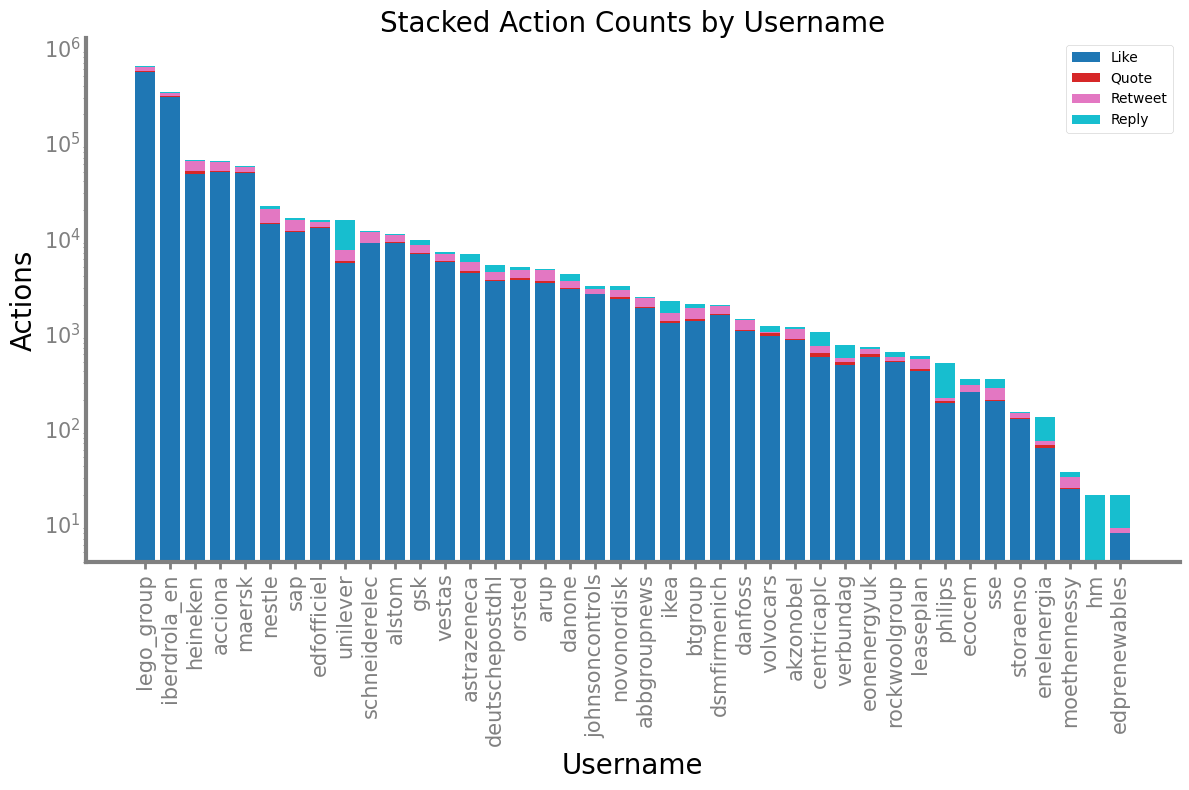

In [108]:
# Plot the results
plt.figure(figsize=(12, 8))

# Use tab10 color palette
tab10_palette = plt.get_cmap('tab10', len(actions))

bottom = np.zeros(len(df_plot))  # Start stacking from zero
for i, action in enumerate(actions):
    plt.bar(df_plot.index, df_plot[f'{action}_count'], bottom=bottom, label=action.capitalize(), color=tab10_palette(i))
    bottom += df_plot[f'{action}_count']  # Update the bottom values for stacking

# Customize the plot
plt.xlabel('Username')
plt.ylabel('Actions')
plt.yscale('log')
plt.title('Stacked Action Counts by Username')
plt.xticks(rotation=90, ha='center')
plt.legend()
plt.grid(False)

plt.tight_layout()
plt.show()


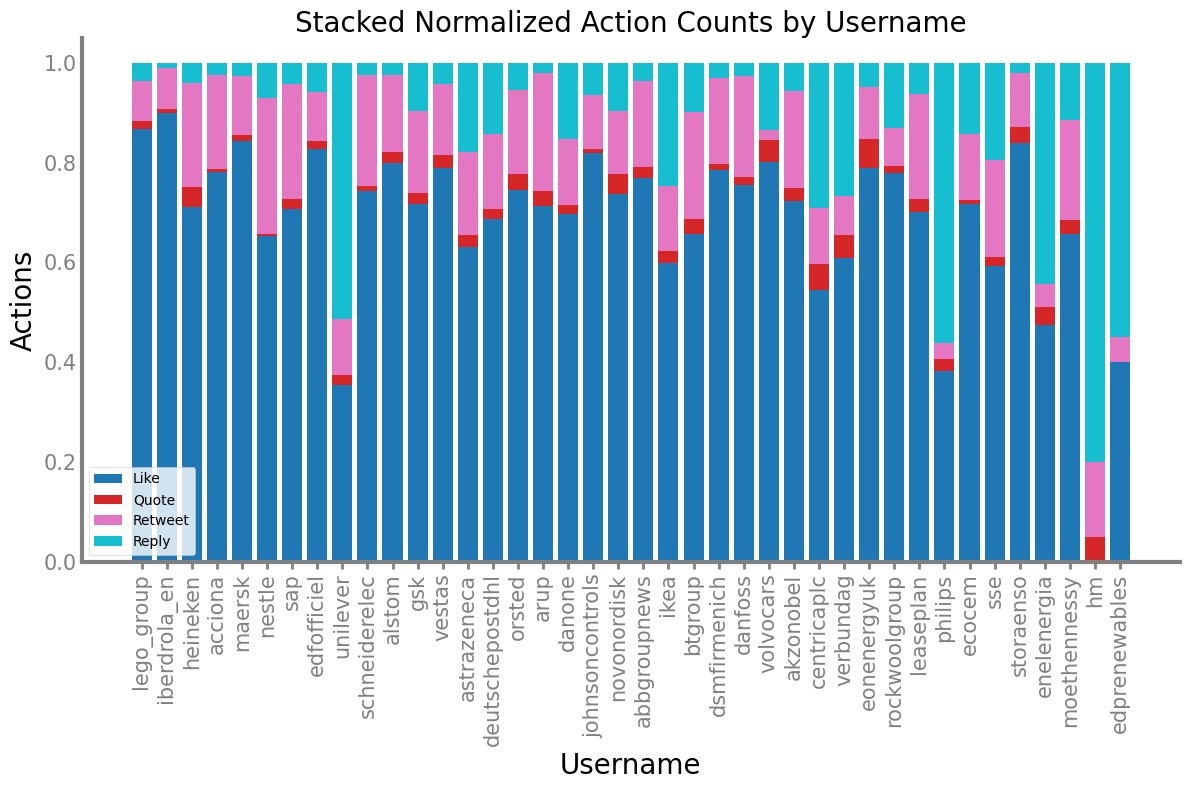

In [109]:
# Plot the results
plt.figure(figsize=(12, 8))

# Use tab10 color palette
tab10_palette = plt.get_cmap('tab10', len(actions))

bottom = np.zeros(len(df_plot))  # Start stacking from zero
for i, action in enumerate(actions):
    plt.bar(df_plot.index, df_plot[f'{action}_count_normalized'], bottom=bottom, label=action.capitalize(), color=tab10_palette(i))
    bottom += df_plot[f'{action}_count_normalized']  # Update the bottom values for stacking

# Customize the plot
plt.xlabel('Username')
plt.ylabel('Actions')
plt.title('Stacked Normalized Action Counts by Username')
plt.xticks(rotation=90, ha='center')
plt.legend()
plt.grid(False)

plt.tight_layout()
plt.show()


#### engagement by user

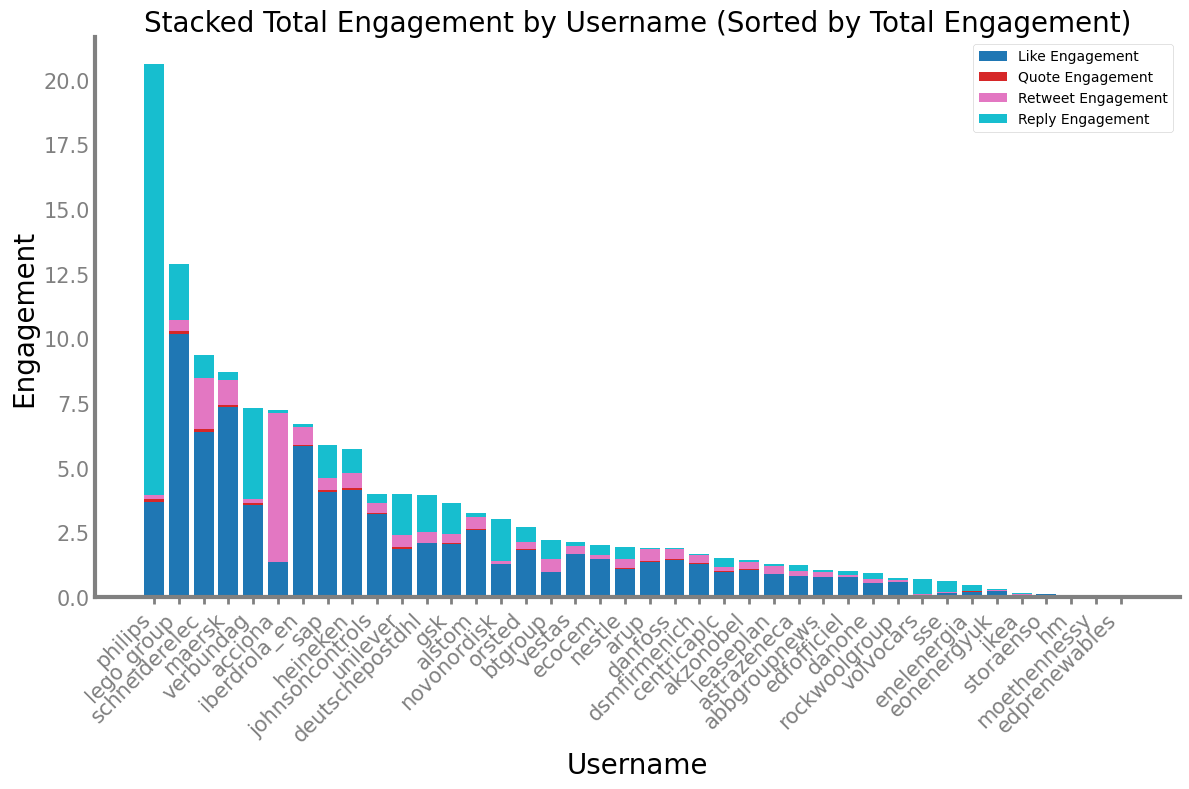

In [75]:
for action in actions:
    df[f'{action}_engagement'] = np.where(df['impression_count'] > 0, df[f'{action}_count'] / df['impression_count'], 0)

# Calculate average engagement for each username
engagement_metrics = df.groupby('username')[[f'{action}_engagement' for action in actions]].sum()

# Calculate total engagement by summing all four actions
engagement_metrics['total_engagement'] = engagement_metrics.sum(axis=1)

# Sort by total engagement in descending order
engagement_metrics_sorted = engagement_metrics.sort_values(by='total_engagement', ascending=False)

# Plot the results
plt.figure(figsize=(12, 8))

# Use tab10 color palette
tab10_palette = plt.get_cmap('tab10', len(actions))

# Iterate through each action and stack the bars
bottom = np.zeros(len(engagement_metrics_sorted))  # Start stacking from zero
for i, action in enumerate(actions):
    plt.bar(engagement_metrics_sorted.index, engagement_metrics_sorted[f'{action}_engagement'], bottom=bottom, label=action.capitalize() + ' Engagement', color=tab10_palette(i))
    bottom += engagement_metrics_sorted[f'{action}_engagement']  # Update the bottom values for stacking

# Customize the plot
plt.xlabel('Username')
plt.ylabel('Engagement')
plt.title('Stacked Total Engagement by Username (Sorted by Total Engagement)')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(False)

plt.tight_layout()
plt.show()


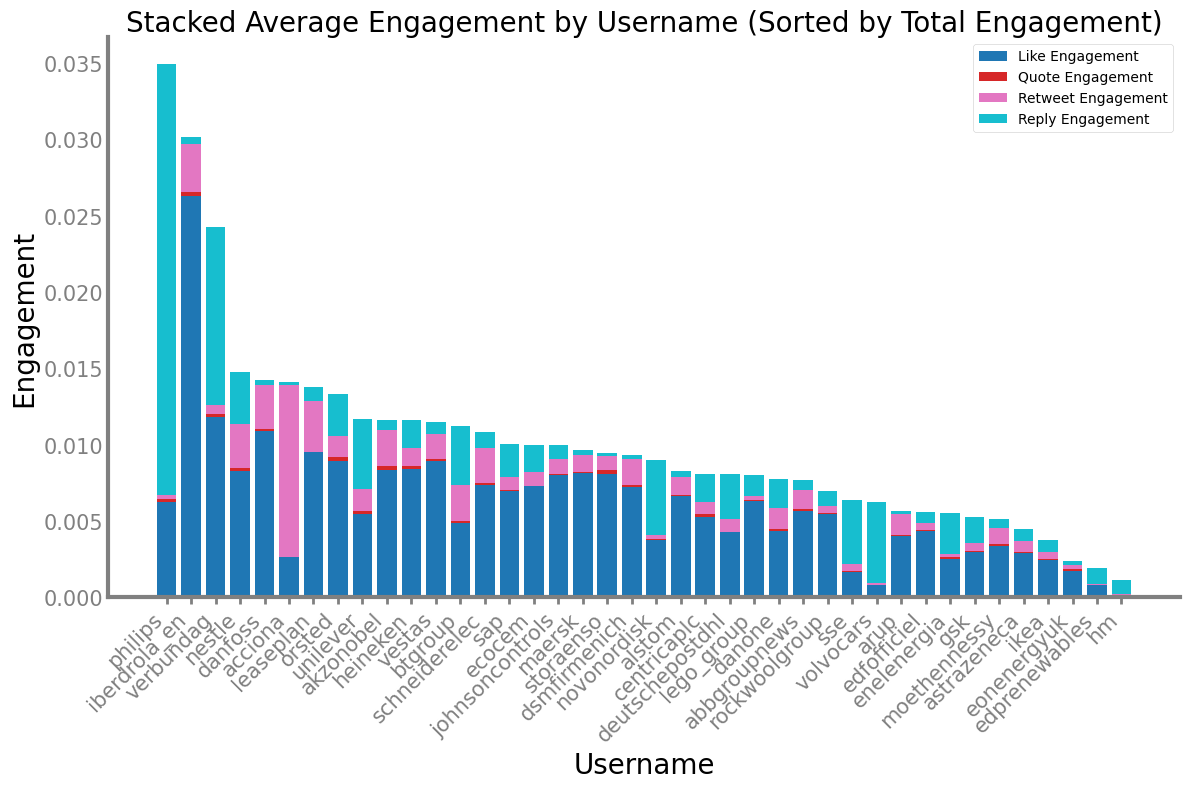

In [76]:
actions = ['like', 'quote', 'retweet', 'reply']
for action in actions:
    df[f'{action}_engagement'] = np.where(df['impression_count'] > 0, df[f'{action}_count'] / df['impression_count'], 0)

# Calculate average engagement for each username
engagement_metrics = df.groupby('username')[[f'{action}_engagement' for action in actions]].mean()

# Calculate total engagement by summing all four actions
engagement_metrics['total_engagement'] = engagement_metrics.sum(axis=1)

# Sort by total engagement in descending order
engagement_metrics_sorted = engagement_metrics.sort_values(by='total_engagement', ascending=False)

# Plot the results
plt.figure(figsize=(12, 8))

# Use tab10 color palette
tab10_palette = plt.get_cmap('tab10', len(actions))

# Iterate through each action and stack the bars
bottom = np.zeros(len(engagement_metrics_sorted))  # Start stacking from zero
for i, action in enumerate(actions):
    plt.bar(engagement_metrics_sorted.index, engagement_metrics_sorted[f'{action}_engagement'], bottom=bottom, label=action.capitalize() + ' Engagement', color=tab10_palette(i))
    bottom += engagement_metrics_sorted[f'{action}_engagement']  # Update the bottom values for stacking

# Customize the plot
plt.xlabel('Username')
plt.ylabel('Engagement')
plt.title('Stacked Average Engagement by Username (Sorted by Total Engagement)')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(False)

plt.tight_layout()
plt.show()


#### engagement vs. number of tweets

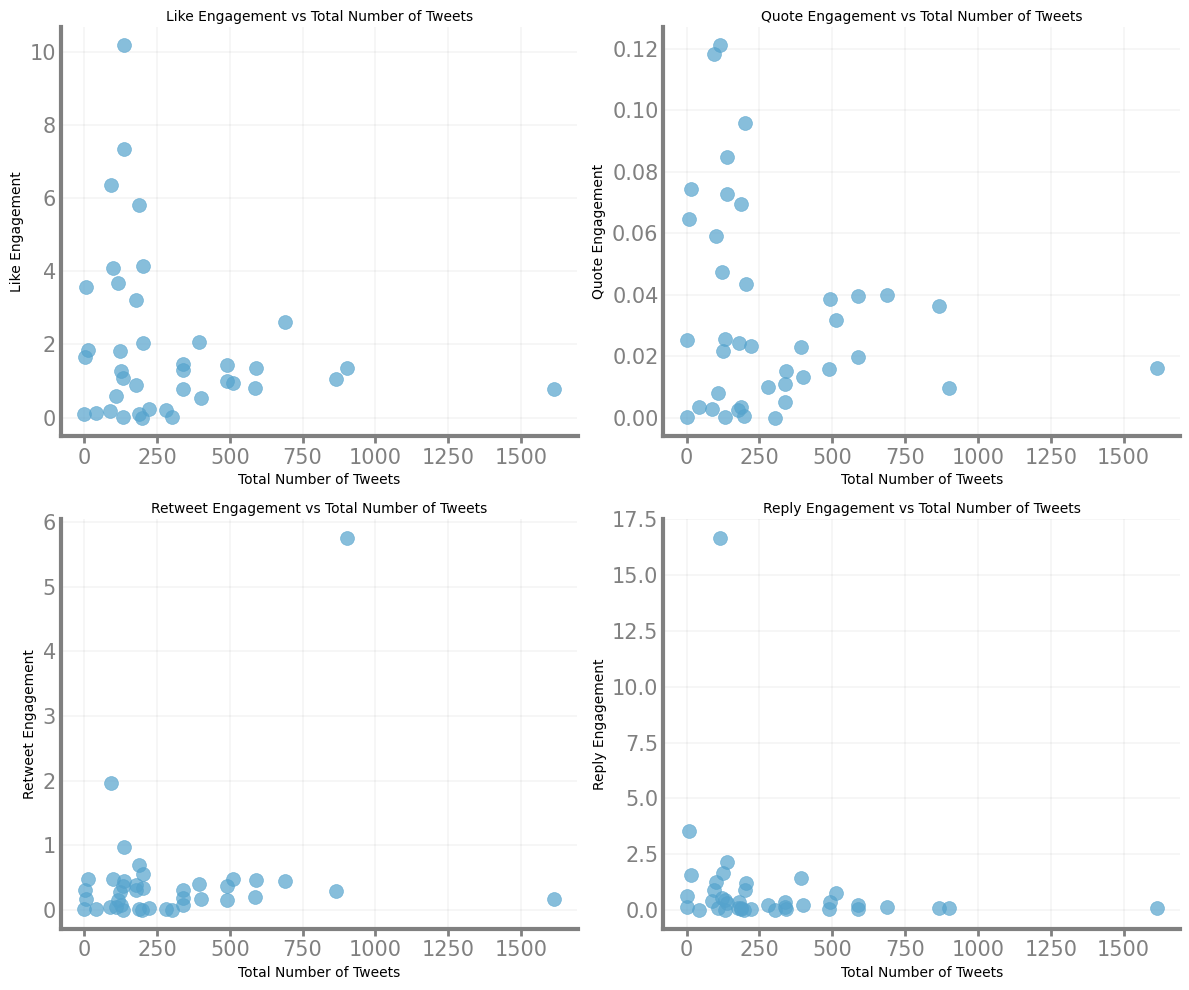

In [77]:
# Compute engagement metrics, avoiding division by zero
actions = ['like', 'quote', 'retweet', 'reply']
for action in actions:
    df[f'{action}_engagement'] = np.where(df['impression_count'] > 0, df[f'{action}_count'] / df['impression_count'], 0)

# Calculate total engagement by summing all four actions
engagement_metrics = df.groupby('username')[[f'{action}_engagement' for action in actions]].sum()

# Calculate total number of tweets per username
tweet_counts = df['username'].value_counts()

# Plot scatter plots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for i, action in enumerate(actions):
    ax = axs[i // 2, i % 2]
    ax.scatter(tweet_counts, engagement_metrics[f'{action}_engagement'], alpha=0.7)
    ax.set_xlabel('Total Number of Tweets', fontsize=10)
    ax.set_ylabel(f'{action.capitalize()} Engagement', fontsize=10)
    ax.set_title(f'{action.capitalize()} Engagement vs Total Number of Tweets', fontsize=10)

plt.tight_layout()
plt.show()

# Hahstags analysis

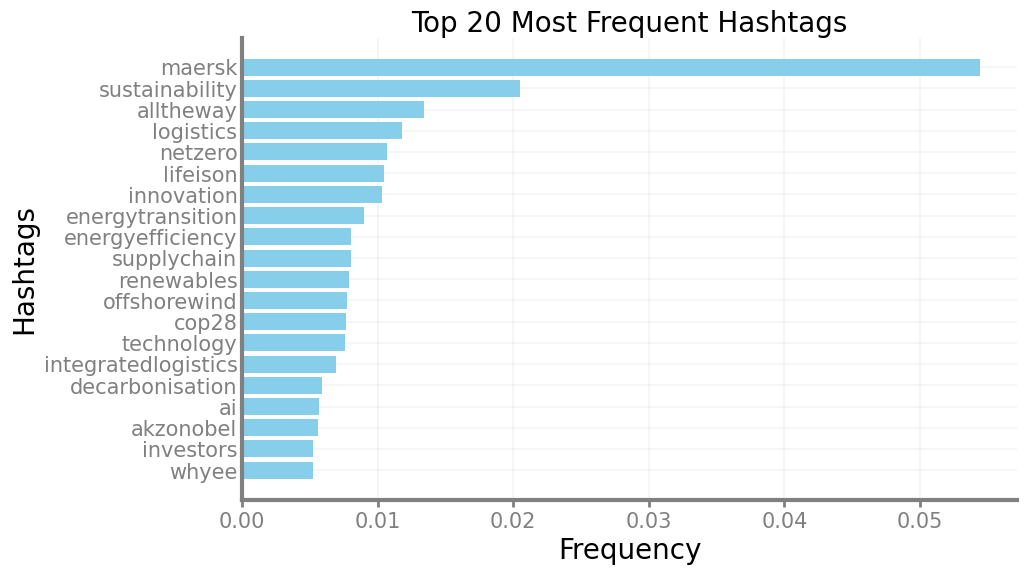

In [141]:
from collections import Counter

all_hashtags = []
# Flatten the list of hashtags
for sublist in df['hashtags']:
    if sublist is not None:
        for tag in sublist:
            all_hashtags.append(tag.lower())
            
# Count the frequency of each hashtag
hashtags_freq = dict(Counter(all_hashtags))
total = Counter(all_hashtags).total()
d = {}
for k,v in hashtags_freq.items():
    d[k] = v/total


# Select the 20 most frequent hashtags
top20_hashtags = sorted(d.items(), key=lambda x: x[1], reverse=True)

# Separate the hashtags and frequencies for plotting
top20_hashtags, top20_counts = zip(*top20_hashtags)

# Plotting the bar plot
plt.figure(figsize=(10, 6))
plt.barh(top20_hashtags[:20], top20_counts[:20], color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Hashtags')
plt.title('Top 20 Most Frequent Hashtags')
plt.gca().invert_yaxis()  # Invert y-axis to show the most frequent at the top
plt.show()

In [142]:
df['hashtags']

0        [ABB, electricvehicles, emobility, sustainabil...
1        [technology, energyefficiency, software, ABBFo...
2        [ABB, data, betterdecisions, ABB_Ability, sust...
3                                                    [ABB]
4        [ABB, podcast, EV, technology, motorsport, ABB...
                               ...                        
12045                                                 None
12046                                                 None
12047                                                 None
12048                                                 None
12049                                                 None
Name: hashtags, Length: 12050, dtype: object

Co-occurrence Matrix:
                         zerodirectemissions  schiene  \
zerodirectemissions                        0        0   
schiene                                    0        0   
partnershipsofthefuture                    0        0   
empowering                                 0        0   
shunting                                   0        0   
...                                      ...      ...   
shipbuilding                               0        0   
domainexpert                               0        0   
oems                                       0        0   
resilient                                  0        0   
growwithsap                                0        0   

                         partnershipsofthefuture  empowering  shunting  \
zerodirectemissions                            0           0         0   
schiene                                        0           0         0   
partnershipsofthefuture                        0           0         0 

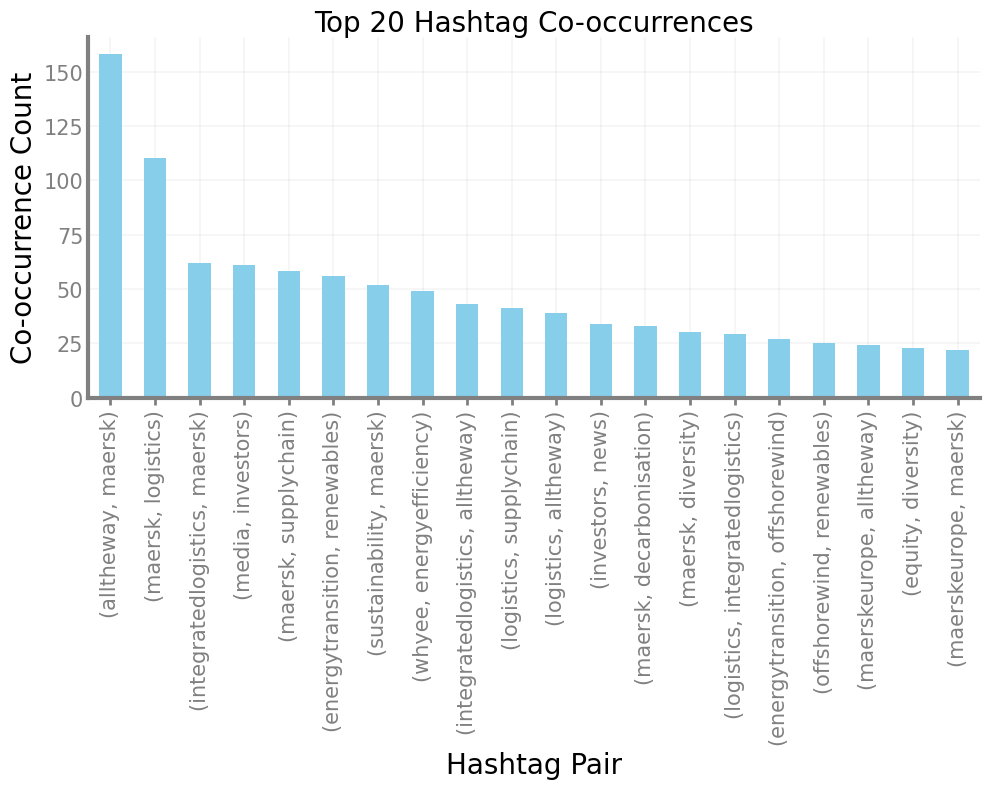

In [155]:
import itertools
all_hashtags = []
# Flatten the list of hashtags
for sublist in df['hashtags']:
    if sublist is not None:
        for tag in sublist:
            all_hashtags.append(tag.lower())

# Initialize an empty co-occurrence matrix
unique_hashtags = list(set(all_hashtags))
co_occurrence_matrix = pd.DataFrame(0, index=unique_hashtags, columns=unique_hashtags)

# Fill the co-occurrence matrix
for hashtags in df['hashtags']:
    if hashtags is not None:
        for h1, h2 in itertools.combinations(hashtags, 2):
            h1 = h1.lower()
            h2 = h2.lower()
            co_occurrence_matrix.at[h1, h2] += 1
            co_occurrence_matrix.at[h2, h1] += 1

# Print the co-occurrence matrix (optional)
print("Co-occurrence Matrix:")
print(co_occurrence_matrix)

# Select top N co-occurrences to visualize (optional)
top_n = 20
top_co_occurrences = co_occurrence_matrix.unstack().sort_values(ascending=False).drop_duplicates()[:top_n]

# Plotting the top co-occurrences
plt.figure(figsize=(10, 8))
top_co_occurrences.plot(kind='bar', color='skyblue')
plt.title(f'Top {top_n} Hashtag Co-occurrences')
plt.xlabel('Hashtag Pair')
plt.ylabel('Co-occurrence Count')
plt.xticks(rotation=90, ha='center')
plt.tight_layout()
plt.show()